In [7]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [8]:
PATH = '/Users/dhyungseoklee/Projects/data/'

In [9]:
df = pd.read_csv(PATH + 'anomaly_data.csv')
df = df.set_index('timestamp')
df.head()

,value
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


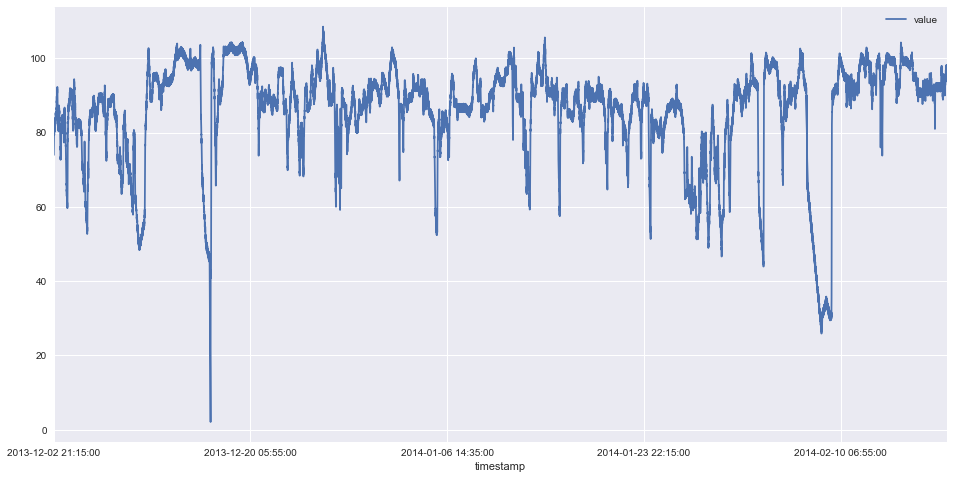

In [10]:
df.plot(figsize=(16,8))

In [11]:
def series_to_supervised(data, n_in, n_out, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    #input sequence (t-n.... t-1)
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names+=[(f'''var{j+1}(t-{i})''') for j in range(n_vars)]
        
    #forecast sequence (t, t+1....t+n)
    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names+=[(f'''var{j+1}(t)''') for j in range(n_vars)]
        else:
            names+=[(f'''var{j+1}(t+{i}''') for j in range(n_vars)]
        
    agg = pd.concat(cols, axis =1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

    

In [12]:
# scale and reframe the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
values = df.values
values_sc = sc.fit_transform(values)

#convert to supervised learning
reframed = series_to_supervised(values_sc,3,1)
reframed.head()

,var1(t-3),var1(t-2),var1(t-1),var1(t)
3,0.675424,0.684525,0.695691,0.714638
4,0.684525,0.695691,0.714638,0.725812
5,0.695691,0.714638,0.725812,0.719992
6,0.714638,0.725812,0.719992,0.734644
7,0.725812,0.719992,0.734644,0.734672


In [14]:
# split the data into train and test
values = reframed.values

# we will use 30% for training and 70% for test to speed up the training process
training_size = 0.3
n_split = round(training_size*22695)
train = values[:n_split, :]
test = values[n_split:, :]

# split in to training and test
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

# reshape input data into 3 Dimensional as LSTM expects
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6808, 1, 3) (15884, 1, 3) (6808,) (15884,)


In [16]:
# baseline modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import warnings 
warnings.filterwarnings('ignore')

K.clear_session()

model = Sequential()
model.add(LSTM(100, input_dim = 3))
model.add(Dense(1))
opt = Adam(learning_rate = 0.005)
model.compile(loss = 'mse', optimizer = opt)

Train on 6808 samples, validate on 15884 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
6808/6808 - 3s - loss: 0.0382 - val_loss: 0.0013
Epoch 2/20
6808/6808 - 1s - loss: 9.2535e-04 - val_loss: 5.8960e-04
Epoch 3/20
6808/6808 - 1s - loss: 3.8163e-04 - val_loss: 2.4715e-04
Epoch 4/20
6808/6808 - 1s - loss: 1.8469e-04 - val_loss: 1.5416e-04
Epoch 5/20
6808/6808 - 1s - loss: 1.4601e-04 - val_loss: 1.3349e-04
Epoch 6/20
6808/6808 - 1s - loss: 1.4003e-04 - val_loss: 1.3034e-04
Epoch 7/20
6808/6808 - 1s - loss: 1.3977e-04 - val_loss: 1.3185e-04
Epoch 8/20
6808/6808 - 1s - loss: 1.4005e-04 - val_loss: 1.3027e-04
Epoch 9/20
6808/6808 - 1s - loss: 1.3894e-04 - val_loss: 1.2690e-04
Epoch 10/20
6808/6808 - 1s - loss: 1.3846e-04 - val_loss: 1.2646e-04
Epoch 11/20
6808/6808 - 1s - loss: 1.3767e-04 - val_loss: 1.2734e-04
Epoch 12/20
6808/6808 - 1s - loss: 1.3726e-04 - val_loss: 1.2893e-04
Epoch 13/20
6808/6808 - 1s - loss: 1.3543e-04 

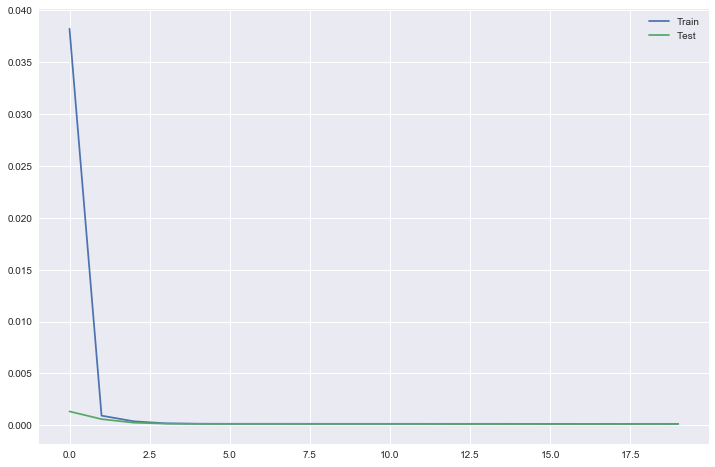

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', verbose = 0)
history = model.fit(X_train, y_train,
                    epochs = 20,
                    batch_size = 64,
                    verbose = 2,
                    callbacks = [es],
                    validation_data = (X_test, y_test))

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Test')
plt.legend()
plt.show()

In [18]:
# evaluate model and prediction
model.evaluate(X_test,y_test, verbose=2)

15884/15884 - 0s - loss: 1.2571e-04


0.00012571237396765585

In [19]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
r2_score(y_test,y_pred)

0.9924113723185959

In [30]:
# calculating root mean squared error 
from sklearn.metrics import mean_squared_error
import math as m

# invert scaling for forecast
X_t = X_test.reshape(X_test.shape[0],X_test.shape[2])
inv_y_pred = np.concatenate((y_pred,X_t),axis=1)
inv_y_p = sc.inverse_transform(inv_y_pred)

# invert scaling for actual
y_t = y_test.reshape(len(y_test),1)
inv_y_ac = np.concatenate((y_t,X_t),axis = 1)
inv_y_a = sc.inverse_transform(inv_y_ac)

inv_y_p = inv_y_p[:,0]
inv_y_a = inv_y_a[:,0]

rmse = m.sqrt(mean_squared_error(inv_y_a, inv_y_p))
print(f''' Test rmse: {rmse}''')


 Test rmse: 1.1932625988702135
